# American Housing Survey Project

Explore year 2013 of national and metro datasets from the [Housing Affordability Data System (HADS)](https://www.huduser.gov/portal/datasets/hads/hads.html) data source.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import os.path

%matplotlib inline



### Read data

In [2]:
# Read Natinal Data 
national_url = 'https://www.huduser.gov/portal/datasets/hads/hads2013n_ASCII.zip'
national_file = 'thads2013n.txt'

if os.path.exists(national_file):
    df_national = pd.read_csv(national_file)
else: 
    z_national = urlopen(national_url)
    zip_national = ZipFile(BytesIO(z_national.read())).extract(national_file)
    df_national = pd.read_csv(zip_national)

In [3]:
df_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64535 entries, 0 to 64534
Data columns (total 99 columns):
CONTROL                64535 non-null object
AGE1                   64535 non-null int64
METRO3                 64535 non-null object
REGION                 64535 non-null object
LMED                   64535 non-null int64
FMR                    64535 non-null int64
L30                    64535 non-null int64
L50                    64535 non-null int64
L80                    64535 non-null int64
IPOV                   64535 non-null int64
BEDRMS                 64535 non-null int64
BUILT                  64535 non-null int64
STATUS                 64535 non-null object
TYPE                   64535 non-null int64
VALUE                  64535 non-null int64
VACANCY                64535 non-null int64
TENURE                 64535 non-null object
NUNITS                 64535 non-null int64
ROOMS                  64535 non-null int64
WEIGHT                 64535 non-null float64
PER 

In [4]:
df_national.head()

,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,...,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,...,'1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5'
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,...,'3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5'
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,...,'2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5'
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,...,'2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5'
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,...,'3 GT FMR','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','7 120% AMI +','0 Not Assisted','1 Less than 30%','-5','-5'


### Exploratory questions
#### Pairwise visualizations

Useful columns 
- `ZINC2`: Household Income
- `ZSMHC`: Monthly Housing Costs

In [5]:
# Make function for scatter plot 
def plot_columns(x_col, y_col, x_name, y_name):
    plt.figure(figsize=(6,6))
    #plt.scatter(df_national[x_col], df_national[y_col], s=10, alpha=0.5)
    plt.scatter(df_national[x_col], df_national[y_col])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

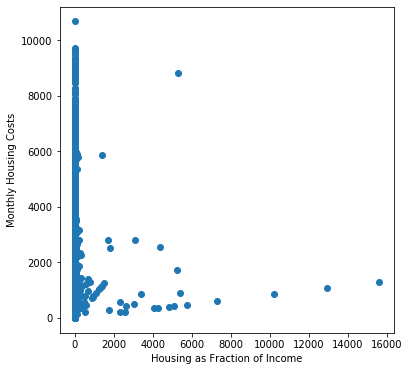

In [6]:
plot_columns(x_col='BURDEN', y_col='ZSMHC', x_name='Housing as Fraction of Income', y_name='Monthly Housing Costs')

In [7]:
df_national.BURDEN.describe()

count    64535.000000
mean         2.063421
std        116.039132
min         -9.000000
25%          0.116927
50%          0.220192
75%          0.375980
max      15600.000000
Name: BURDEN, dtype: float64

In [8]:
error = 0

In [9]:
range(len(df_national.BURDEN))

range(0, 64535)

In [10]:
for row in range(len(df_national.BURDEN)):
    if df_national.BURDEN[row] > 1:
        error += 1


In [11]:
error

4516

In [12]:
(df_national.BURDEN > 1).sum()

4516

In [13]:
df_national.ZINC2.describe()

count    6.453500e+04
mean     6.135584e+04
std      7.440530e+04
min     -1.170000e+02
25%      1.498700e+04
50%      3.998700e+04
75%      8.123100e+04
max      1.061921e+06
Name: ZINC2, dtype: float64

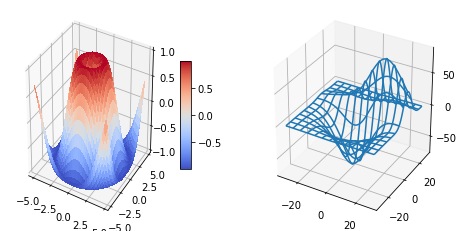

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
X, Y, Z = get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()